This tutorial uses the PSF operators derived in tutorials 5 and 6 to perform Ac225 reconstruction in PyTomography. For more details on PyTommography, as well as tutorials, see [this link](https://pytomography.readthedocs.io/en/latest/usage.html)

In [1]:
import torch
import dill
import pytomography
from pytomography.io.SPECT import simind
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.transforms.SPECT  import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata, subsample_amap
from pytomography.likelihoods import PoissonLogLikelihood
import matplotlib.pyplot as plt


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


A lot of the code below uses PyTomography for image reconstruction: you can see more details on how to reconstruct SIMIND data here [here](https://pytomography.readthedocs.io/en/latest/notebooks/t_siminddata.html)

* The data corresponds to a cylindrical phantom with warm background and 3 hot spheres.

In [2]:
dT = 3.5 * 60 # seconds per projection
activity = 100 # mBq
CPSpMBq = 19.4796

photopeak_path = '/disk1/ac225/bi213_bkg_proj/tot_w8.h00'
scatter_path = '/disk1/ac225/bi213_bkg_proj/sca_w8.h00'
amap = simind.get_attenuation_map('/disk1/ac225/bi213_proj/amap.hct')

object_meta, proj_meta = simind.get_metadata(photopeak_path)
projectionss = simind.get_projections([photopeak_path, scatter_path])
# Subsample to lower resolution
object_meta, proj_meta, projectionss = subsample_projections_and_modify_metadata(object_meta, proj_meta, projectionss, N_pixel = 2, N_angle=4)
amap = subsample_amap(amap, 2)
# Get photopeak and scatter
photopeak = torch.poisson(projectionss[0]*activity*dT)
scatter = torch.poisson(projectionss[1]*activity*dT)

The code below reconstructs using MLEM(30it,1ss)

In [3]:
def perform_reconstruction(psf_transform):
    att_transform = SPECTAttenuationTransform(attenuation_map=amap)
    system_matrix = SPECTSystemMatrix(
            obj2obj_transforms = [att_transform,psf_transform],
            proj2proj_transforms = [],
            object_meta = object_meta,
            proj_meta = proj_meta)
    likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter)
    algorithm = OSEM(likelihood)
    return algorithm(n_iters=30, n_subsets=1)

1D-R reconstruction using psf operator saved from tutorial 5

In [4]:
with open(f'/home/gpuvmadm/PointSpreadFunctionFitter/notebook_testing/psf_operator_1D.pkl', 'rb') as f:
    psf_operator = dill.load(f)
psf_operator.set_device(pytomography.device)
psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
recon_1Dfit = perform_reconstruction(psf_transform)

2D reconstruction using psf operator saved from tutorial 6. This takes about 2.5 times longer than using the psf operator above

In [5]:
with open('/home/gpuvmadm/PointSpreadFunctionFitter/notebook_testing/psf_kernel_nearest_multi.pkl', 'rb') as file:
    psf_operator = dill.load(file)
psf_operator.set_device(pytomography.device)
psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
recon2D = perform_reconstruction(psf_transform)

Reconstruction that doesn't take into account septal penetration or scatter

In [6]:
psf_meta = simind.get_psfmeta_from_header('/disk1/ac225/bi213_bkg_proj/tot_w8.h00')
psf_transform = SPECTPSFTransform(psf_meta)
reconbad = perform_reconstruction(psf_transform)

Lets compare the two reconstructions: the first one using the fitted PSF and the second one using the Monte Carlo kernels. Note that the fitted one was over twice as fast for reconstructing!

In [8]:
recons = [reconbad, recon_1Dfit, recon2D]

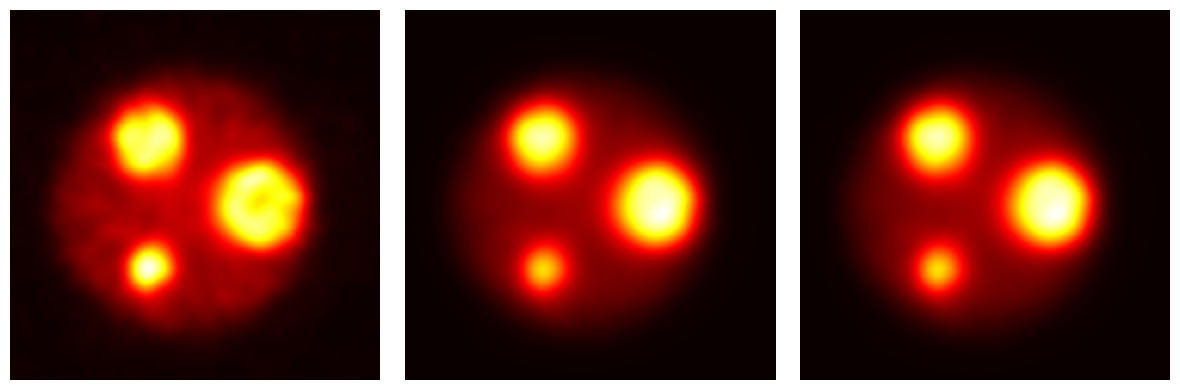

In [9]:
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(3):
    plt.sca(ax[i])
    plt.imshow(recons[i].cpu().numpy()[:,:,64], cmap='hot', interpolation='gaussian')
    plt.axis('off')
    plt.xlim(35,95)
    plt.ylim(35,95)
fig.tight_layout()

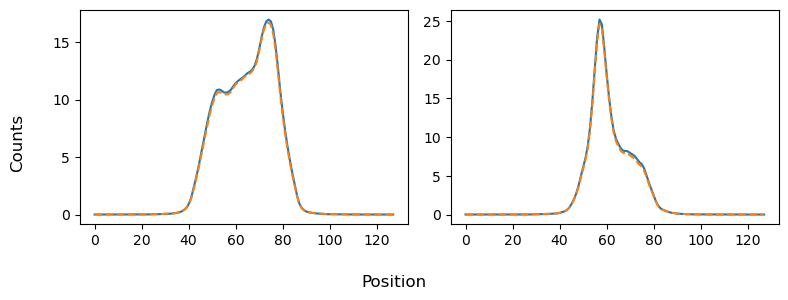

In [10]:
fig = plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(recon_1Dfit.cpu().numpy()[:,64,64])
plt.plot(recon2D.cpu().numpy()[:,64,64], ls='--')
plt.subplot(122)
plt.plot(recon_1Dfit.cpu().numpy()[50,:,64])
plt.plot(recon2D.cpu().numpy()[50,:,64], ls='--')
fig.supxlabel('Position')
fig.supylabel('Counts')
fig.tight_layout()

Very similar!

In [11]:
torch.save(reconbad, '/disk1/psf_data/toolbox_plots_data/ac225_reconbad.pt')
torch.save(recon_1Dfit, '/disk1/psf_data/toolbox_plots_data/ac225_recon1Dfit.pt')
torch.save(recon2D, '/disk1/psf_data/toolbox_plots_data/ac225_recon2D.pt')